# Existing Smallplexes in Los Angeles

For our group project, my team is researching the potential impact that the recently passed SB 9 can have on the supply of housing in Los Angeles California. One of our data sources will higlight lots in the city with existing smallplexes. This can potentially show the lack of availability of smallplexes as a housing option for Los Angeles residents, and how SB 9 can make smallplexes in Los Angeles a more common and affordable housing option. The dataset I used is the Building Permit Database available [here](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Permit-Information-Old/yv23-pmwf/data).  

We also wanted to highlight the neighborhoods that currently have smallplexes as housing options and the neighborhoods that do not. This can potentially show that smallplexes are effective housing options for households with low to middle income. The dataset I used for neighborhoods is the LA Times Neighborhood Data available [here](https://geohub.lacity.org/datasets/la-times-neighborhood-boundaries/explore)

For the purposes of this notebook, smallplexes will be defined as any strcture that has 2 to 4 housing units on the same lot. This notebook goes on to highlight the availability of smallplexes prior to the implementation of SB 9. 

## Step 1

I imported all the libraries I potentially need.

In [1]:
import pandas as pd

import geopandas as gpd

import contextily as ctx

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

import matplotlib.pyplot as plt

import plotly.express as px

## Step 2

I imported both datasets I will be using in this notebook

In [2]:
Smallplex_Data = gpd.read_file('data/Smallplex Data.csv')

In [3]:
Neighborhood_Boundaries = gpd.read_file('data/LA_Times_Neighborhood_Boundaries.zip')

## Step 3

I explored the smallplex data like I did in the previous weeks.

In [4]:
Smallplex_Data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   Assessor Book                             2352 non-null   object  
 1   Assessor Page                             2352 non-null   object  
 2   Assessor Parcel                           2352 non-null   object  
 3   Tract                                     2352 non-null   object  
 4   Block                                     2352 non-null   object  
 5   Lot                                       2352 non-null   object  
 6   Reference # (Old Permit #)                2352 non-null   object  
 7   PCIS Permit #                             2352 non-null   object  
 8   Status                                    2352 non-null   object  
 9   Status Date                               2352 non-null   object  
 10  Permit Type     

In [5]:
Smallplex_Data.sample(5)

Assessor Book Assessor Page Assessor Parcel  \
222           2245             1              24   
1858          6052             4              19   
7             5076             4              12   
907           6083            10              26   
1913          5101            33              12   

                                                  Tract Block  Lot  \
222                                             TR 8126         50   
1858                                            TR 6214         21   
7                  CLARK AND BRYAN'S WESTMORELAND TRACT        107   
907                                             TR 3598         99   
1913  THE MC CARTHY COMPANY'S MAIN STREET MONETA AVE...     B   26   

     Reference # (Old Permit #)      PCIS Permit #          Status  \
222                   16VN29890  13010-20000-03547  CofO Corrected   
1858                  14SL53203  14010-10000-00568  CofO Corrected   
7                     17LA82547  17016-10000-05525     CofO Issued   
907                   18SL65377  18010-70000-03505     CofO Issued   
1913                  14LA34073  14010-10000-01355     CofO Issued   

     Status Date  ...   Applicant Address 1 Applicant Address 2  \
222        44466  ...  635 W COLORADO BLVD.                       
1858       42328  ...    7634 RAMISH AVENUE                       
7          44008  ...        4430 W PICO BL                       
907        43636  ...          PO BOX 40915                       
1913       42026  ...  19841 LEXINGTON LANE                       

       Applicant Address 3      Zone Occupancy  \
222           GLENDALE, CA  [Q]RD2-1             
1858      BELL GARDENS, CA      R2-1             
7          LOS ANGELES, CA      R4-1             
907             DOWNEY, CA      R2-1             
1913  HUNTINGTON BEACH, CA      R2-1             

     Floor Area-L.A. Building Code Definition Census Tract  Latitude  \
222                                     10177      1286.01  33.97501   
1858                                     3061         2405  33.95634   
7                                           0      2134.01  34.16404   
907                                      3854      2410.01  33.99399   
1913                                     2997         2328  33.97211   

       Longitude geometry  
222   -118.41662     None  
1858  -118.26111     None  
7     -118.36134     None  
907   -118.28786     None  
1913  -118.37037     None  

[5 rows x 56 columns]

## Step 4 

I added a geometry column because the CSV file did not  come with one.

In [6]:
Smallplex_Data_With_Geometry = gpd.GeoDataFrame(Smallplex_Data,
                                                crs='epsg:4326',
                                                geometry= gpd.points_from_xy(Smallplex_Data.Longitude, Smallplex_Data.Latitude))

In [7]:
Smallplex_Data_With_Geometry.sample(5)

Assessor Book Assessor Page Assessor Parcel  \
389           6047             1               6   
929           6075            29              28   
1965          6083             9              21   
276           2701            75             ***   
1992          4312            17              33   

                                                  Tract Block   Lot  \
389   GRIDER-HAMILTON OSWALD COMPANY'S MANCHESTER HE...          55   
929               BOWENS MAIN MONETA AND FIGUEROA TRACT          41   
1965                                            TR 3598         114   
276                                            TR 53783        LT 1   
1992                                            TR 5522          37   

     Reference # (Old Permit #)      PCIS Permit #          Status  \
389                   19LA20767  18010-30000-06291     CofO Issued   
929                   15SL55825  14010-70000-00352     CofO Issued   
1965                  14LA26777  13010-10000-02705     CofO Issued   
276                   14VN75465  13010-20000-04567  CofO Corrected   
1992                  15LA48868  15010-10000-00528     CofO Issued   

     Status Date  ...      Applicant Address 1 Applicant Address 2  \
389        43862  ...           7117 ALVERN ST                E126   
929        42382  ...                                                
1965       41822  ...             P.O. BOX 410                       
276        42020  ...          11280 CORBIN AV                       
1992       42773  ...  1171 S. ROBERTSON BLVD.               # 550   

     Applicant Address 3    Zone Occupancy  \
389               LA, CA  C2-1VL             
929                         R2-1             
1965    SUNSET BEACH, CA    R2-1             
276       NORTHRIDGE, CA   C4-2D             
1992     LOS ANGELES, CA    C2-1             

     Floor Area-L.A. Building Code Definition Census Tract  Latitude  \
389                                      2170         2382  33.77838   
929                                      3060      2412.02  33.98433   
1965                                     3549      2410.01  34.06707   
276                                      6238      1082.02  34.02751   
1992                                     3135         2702  33.98614   

       Longitude                     geometry  
389   -118.27654  POINT (-118.27654 33.77838)  
929   -118.27545  POINT (-118.27545 33.98433)  
1965  -118.26567  POINT (-118.26567 34.06707)  
276   -118.19704  POINT (-118.19704 34.02751)  
1992   -118.2752  POINT (-118.27520 33.98614)  

[5 rows x 56 columns]

## Step 5 

I cleaned up the dataset by dropping the unimportant columns

In [8]:
columns_to_keep = ['PCIS Permit #',
                   'Permit Type',
                   'Initiating Office',
                   'Issue Date',
                   'Zip Code',
                   'Valuation',
                   '# of Residential Dwelling Units',
                   'Census Tract',
                   'Latitude',
                   'Longitude',
                   'Zone',
                   'geometry']

In [9]:
Smallplex_Data_With_Geometry = Smallplex_Data_With_Geometry[columns_to_keep]

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
Smallplex_Data_With_Geometry.sample(5)

PCIS Permit #        Permit Type Initiating Office Issue Date  \
940   18010-10000-01742           Bldg-New             METRO      43501   
1093  17010-10000-02123           Bldg-New             METRO      42943   
935   17016-20000-35183  Bldg-Alter/Repair          VAN NUYS      43272   
990   18010-10000-01678           Bldg-New             METRO      43272   
288   13010-10000-00824           Bldg-New             METRO      41715   

     Zip Code Valuation # of Residential Dwelling Units Census Tract  \
940     90025    330000                               2         2677   
1093    90003    408000                               2      2397.02   
935     90043     70000                               2      2349.02   
990     90004    325000                               2       1924.2   
288     90094   1264215                               3      2756.02   

      Latitude   Longitude      Zone                     geometry  
940    33.9493   -118.2728      R3-1  POINT (-118.27280 33.94930)  
1093    34.026  -118.19448      R3-1  POINT (-118.19448 34.02600)  
935   33.96144   -118.2758  C2-2D-SP  POINT (-118.27580 33.96144)  
990   34.03088  -118.33366      R3-1  POINT (-118.33366 34.03088)  
288   33.94025  -118.26872    R4(PV)  POINT (-118.26872 33.94025)

## Step 6 

I changed Latitude and Longitude to 'float' to better manipulate the data.

In [12]:
Smallplex_Data_With_Geometry['Latitude'] = Smallplex_Data_With_Geometry.Latitude.astype(float)
Smallplex_Data_With_Geometry['Longitude'] = Smallplex_Data_With_Geometry.Longitude.astype(float)

## Step 7 

I mapped out the existing smallplexes in Los Angeles and separated them into duplexes, triplexes, and quadplexes.

In [13]:
Smallplex_Data_With_Geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
Smallplex_Data_With_Geometry = Smallplex_Data_With_Geometry.to_crs(epsg=3857)

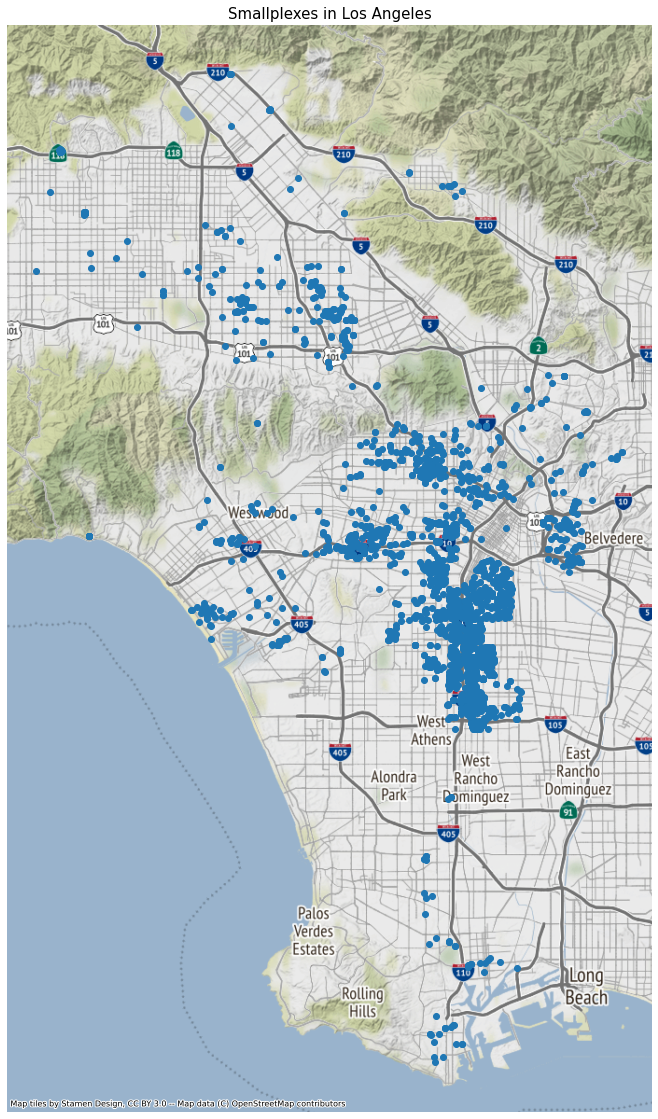

In [15]:
ax = Smallplex_Data_With_Geometry.plot(figsize=(20,20))
ax.set_title('Smallplexes in Los Angeles', fontsize = 15)
ax.axis('off')
ctx.add_basemap(ax)

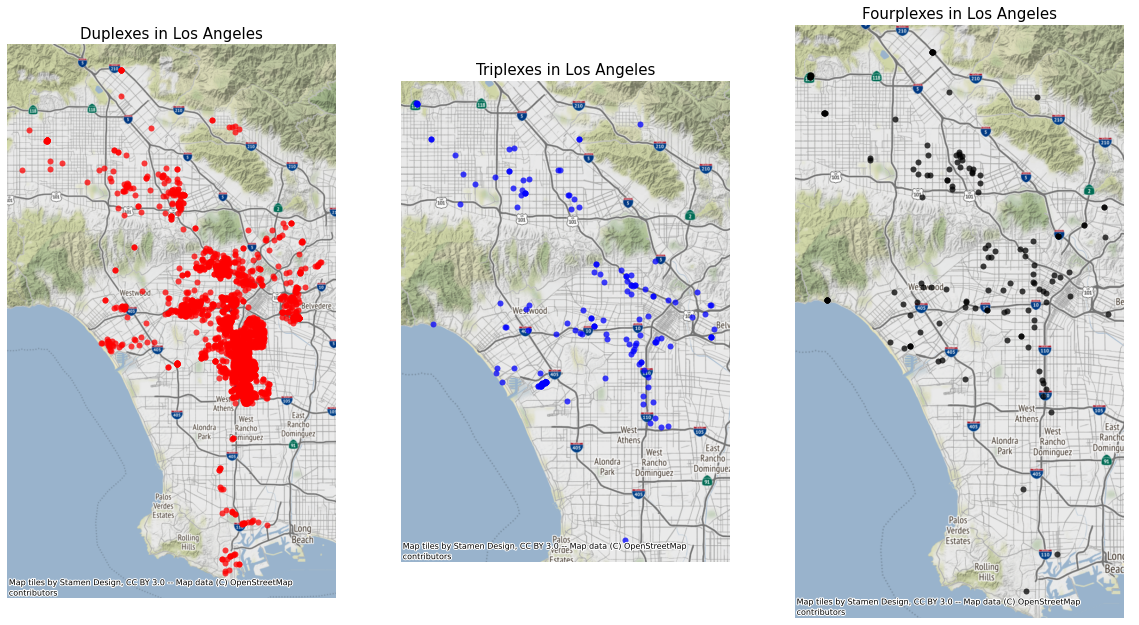

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
ax1, ax2, ax3 = axs

Smallplex_Data_With_Geometry[Smallplex_Data_With_Geometry['# of Residential Dwelling Units'] == '2'].plot(figsize=(20,20), color = 'r', linewidth = 0, alpha = 0.75, ax = ax1)
ax1.axis("off")
ax1.set_title('Duplexes in Los Angeles', fontsize=15)
ctx.add_basemap(ax1)

Smallplex_Data_With_Geometry[Smallplex_Data_With_Geometry['# of Residential Dwelling Units'] == '3'].plot(figsize=(20,20), color = 'b', linewidth = 0, alpha = 0.75, ax = ax2)
ax2.axis("off")
ax2.set_title('Triplexes in Los Angeles', fontsize=15)
ctx.add_basemap(ax2)

Smallplex_Data_With_Geometry[Smallplex_Data_With_Geometry['# of Residential Dwelling Units'] == '4'].plot(figsize=(20,20), color = 'black', linewidth = 0, alpha = 0.75, ax = ax3)
ax3.axis("off")
ax3.set_title('Fourplexes in Los Angeles', fontsize=15)
ctx.add_basemap(ax3)

## Step 8 

I will now be exploring the neighborhood dataset that I imported at the beginning

In [17]:
Neighborhood_Boundaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  114 non-null    int64   
 1   name      114 non-null    object  
 2   geometry  114 non-null    geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 2.8+ KB


In [18]:
Neighborhood_Boundaries.sample(5)

OBJECTID            name  \
51         52  Jefferson Park   
78         79          Reseda   
52         53       Koreatown   
109       110      Wilmington   
28         29    Elysian Park   

                                              geometry  
51   POLYGON ((-118.31335 34.03721, -118.30900 34.0...  
78   POLYGON ((-118.55822 34.18657, -118.56223 34.1...  
52   POLYGON ((-118.28785 34.06182, -118.28783 34.0...  
109  MULTIPOLYGON (((-118.28331 33.75532, -118.2880...  
28   POLYGON ((-118.24246 34.09391, -118.24057 34.0...

In [19]:
columns_to_keep_2 = ['name',
                     'geometry']

In [20]:
Neighborhood_Boundaries = Neighborhood_Boundaries[columns_to_keep_2]

In [21]:
Neighborhood_Boundaries.sample(5)

name                                           geometry
110  Windsor Square  POLYGON ((-118.31404 34.06254, -118.31420 34.0...
41      Harbor City  POLYGON ((-118.29902 33.80355, -118.29903 33.8...
113     Lake Balboa  POLYGON ((-118.50116 34.22114, -118.50116 34.2...
39     Hancock Park  POLYGON ((-118.32596 34.07623, -118.32581 34.0...
30           Encino  MULTIPOLYGON (((-118.51642 34.18100, -118.5182...

<AxesSubplot:>

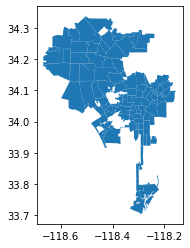

In [22]:
Neighborhood_Boundaries.plot()

In [23]:
Neighborhood_Boundaries = Neighborhood_Boundaries.to_crs(epsg=3857)

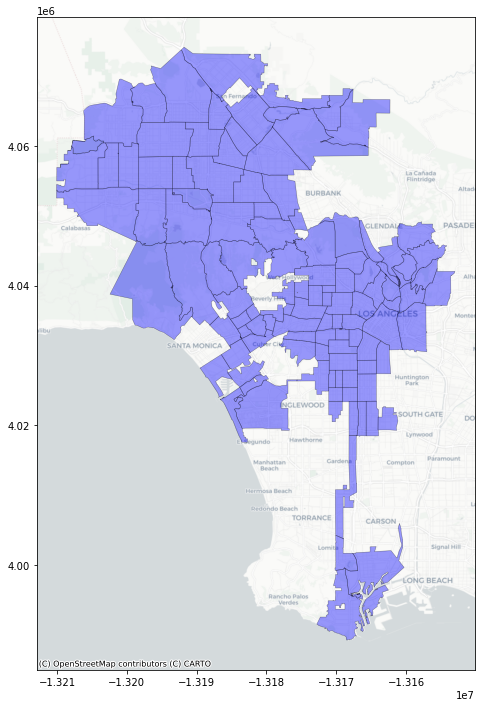

In [24]:
fig, ax = plt.subplots(figsize=(12,12))

Neighborhood_Boundaries.plot(ax=ax,
         color='blue', 
         edgecolor='black',
         lw=0.5,
         alpha=0.4)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Step 9 

I then overlayed smallplex data on top of the neighborhood dataset

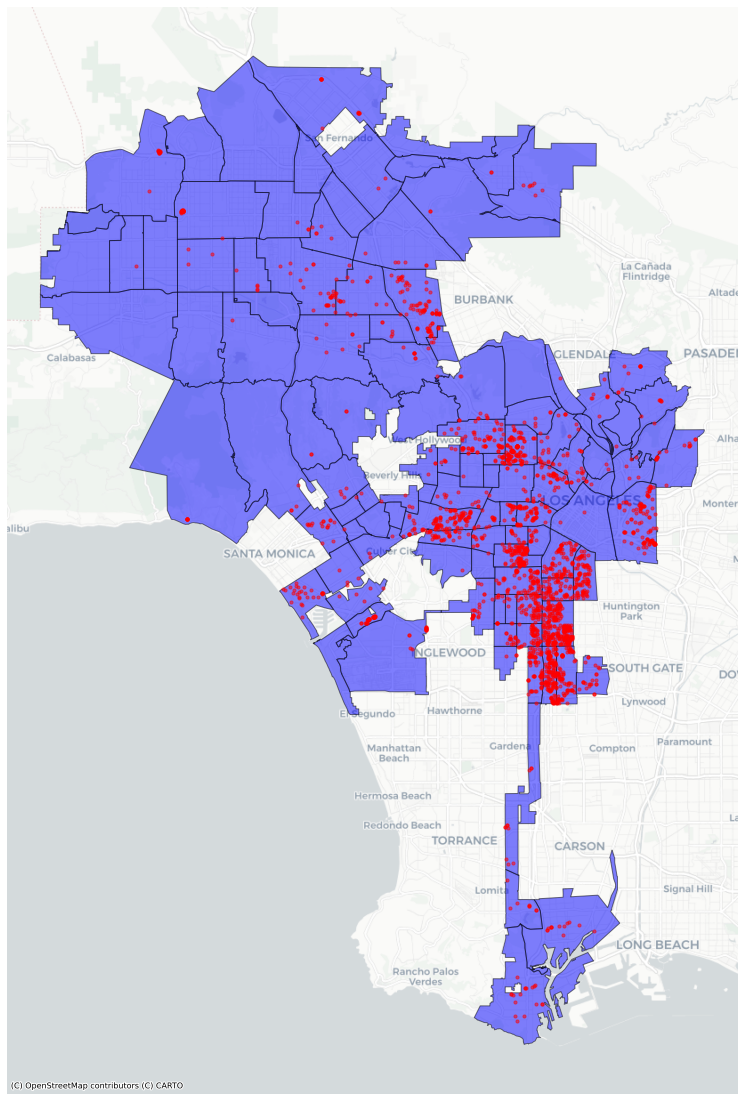

In [25]:
fig, ax = plt.subplots(figsize=(20, 20))

Neighborhood_Boundaries.plot(ax=ax,
        color='blue', 
        edgecolor='black',
        alpha=0.5)

Smallplex_Data_With_Geometry.plot(ax=ax,
            color='red',
            markersize=10,
            alpha=0.5)


ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [26]:
Combined_Data = gpd.sjoin(Smallplex_Data_With_Geometry, Neighborhood_Boundaries,how='left')

Combined_Data.head(10)

PCIS Permit #        Permit Type Initiating Office Issue Date Zip Code  \
0  19010-20000-02371           Bldg-New          VAN NUYS      44134    90016   
1  17010-30000-00174           Bldg-New           WEST LA      43010    90035   
2  13010-20000-00689           Bldg-New          VAN NUYS      42004    91401   
3  16014-30000-06026      Bldg-Addition           WEST LA      43417    90007   
4  19010-20000-03276           Bldg-New          VAN NUYS      43851    91405   
5  19010-20000-03278           Bldg-New          VAN NUYS      43851    91405   
6  18014-10000-04349      Bldg-Addition             METRO      43858    90006   
7  17016-10000-05525  Bldg-Alter/Repair             METRO      42873    90006   
8  18010-20000-01339           Bldg-New          VAN NUYS      43343    91601   
9  15010-10001-03646           Bldg-New             METRO      42558    90272   

  Valuation # of Residential Dwelling Units Census Tract  Latitude  Longitude  \
0    800000                               4      2199.02  34.03317 -118.36779   
1   1780000                               4         2690  34.05319 -118.40537   
2    900000                               4      1286.01  34.17860 -118.44681   
3    950000                               4         2226  34.02108 -118.29312   
4    983714                               4       1235.1  34.19371 -118.42782   
5    983714                               4       1235.1  34.04936 -118.27833   
6    100000                               4       2095.2  34.05287 -118.28758   
7     20000                               4      2134.01  34.16404 -118.36134   
8    680000                               4         1256  34.04136 -118.55527   
9    723300                               4      2626.04  34.08662 -118.34757   

           Zone                           geometry  index_right  \
0       RD1.5-1  POINT (-13176642.109 4033256.817)          103   
1  [Q]RD2-1VL-O  POINT (-13180825.496 4035946.382)           72   
2    [Q]RD1.5-1  POINT (-13185438.575 4052808.928)           96   
3       RD1.5-1  POINT (-13168329.883 4031632.906)           31   
4    [Q]RD1.5-1  POINT (-13183324.618 4054842.299)           94   
5    [Q]RD1.5-1  POINT (-13166683.467 4035431.795)           73   
6     C1-1-HPOZ  POINT (-13167713.173 4035903.387)          106   
7          R4-1  POINT (-13175924.098 4050849.916)           91   
8       RD1.5-1  POINT (-13197512.287 4034357.017)           68   
9         RD2-1  POINT (-13174391.229 4040438.914)           32   

                name  
0         West Adams  
1     Pico-Robertson  
2           Van Nuys  
3    Exposition Park  
4        Valley Glen  
5         Pico-Union  
6           Westlake  
7        Toluca Lake  
8  Pacific Palisades  
9            Fairfax

## Step 10 

I then identified which neighborhoods had the most smallplexes

In [27]:
Smallplexes_By_Neighborhood = Combined_Data.name.value_counts().rename_axis('name').reset_index(name='smallplexes')

In [28]:
Smallplexes_By_Neighborhood

name  smallplexes
0                 Florence          258
1      Broadway-Manchester          147
2           East Hollywood          114
3            Boyle Heights          111
4          Exposition Park          110
5                 Mid-City          107
6          Central-Alameda           92
7            Green Meadows           88
8   Historic South-Central           84
9          North Hollywood           77
10          Vermont Square           77
11           Vermont Vista           69
12               Hollywood           68
13         Vermont-Slauson           60
14              South Park           59
15              Pico-Union           56
16          Vermont Knolls           53
17                Westlake           39
18             Playa Vista           35
19              West Adams           33
20                Van Nuys           30
21                  Venice           29
22                   Watts           24
23              Northridge           24
24               Hyde Park           23
25             Silver Lake           21
26               Echo Park           19
27               San Pedro           18
28         Harvard Heights           17
29             Valley Glen           17
30                Sawtelle           17
31       Manchester Square           15
32             Westchester           15
33               El Sereno           15
34               Larchmont           14
35                  Sylmar           13
36            Mid-Wilshire           13
37              Wilmington           13
38              Chatsworth           13
39          Harbor Gateway           12
40          Jefferson Park           12
41         University Park           12
42       Arlington Heights           11
43     Chesterfield Square           11
44              Eagle Rock           10
45         Adams-Normandie           10
46         Hollywood Hills           10
47             Studio City            9
48               Koreatown            8
49           Glassell Park            8
50             Harbor City            8
51                 Tujunga            7
52               Los Feliz            7
53            Sherman Oaks            7
54           Highland Park            7
55       Pacific Palisades            7
56                 Fairfax            6
57            Harvard Park            6
58             Toluca Lake            6
59              Sun Valley            6
60           Panorama City            5
61             Lake Balboa            5
62         Lincoln Heights            5
63                 Del Rey            5
64          Valley Village            5
65               Brentwood            4
66                Westwood            4
67           Beverly Grove            4
68               Mar Vista            4
69          Pico-Robertson            4
70             North Hills            3
71                   Palms            3
72           Gramercy Park            3
73                  Reseda            3
74               Chinatown            3
75                 Sunland            2
76                 Bel-Air            2
77                 Pacoima            2
78           Beverly Crest            2
79            Elysian Park            2
80                Downtown            2
81            Shadow Hills            2
82        West Los Angeles            1
83            Leimert Park            1
84            Cypress Park            1
85            Hancock Park            1
86            Century City            1
87             Rancho Park            1
88  Baldwin Hills/Crenshaw            1
89       Montecito Heights            1
90                  Encino            1
91             Canoga Park            1
92         Atwater Village            1

In [29]:
Neighborhood_Boundaries=Neighborhood_Boundaries.merge(Smallplexes_By_Neighborhood,on='name')

In [30]:
Neighborhood_Boundaries.sample(10)

name                                           geometry  \
10     Canoga Park  POLYGON ((-13201216.027 4060137.481, -13201214...   
19      Eagle Rock  POLYGON ((-13157763.797 4049176.634, -13157764...   
35    Harvard Park  POLYGON ((-13169970.419 4025387.888, -13170095...   
31    Hancock Park  POLYGON ((-13171985.141 4039042.010, -13171969...   
27        Florence  POLYGON ((-13164247.929 4026447.458, -13164242...   
57           Palms  POLYGON ((-13178931.084 4032762.480, -13178866...   
54      Northridge  POLYGON ((-13191258.385 4058596.832, -13191237...   
59  Pico-Robertson  POLYGON ((-13177701.431 4036988.829, -13177698...   
16    Cypress Park  POLYGON ((-13160082.354 4040761.894, -13159992...   
52     North Hills  POLYGON ((-13190830.720 4058412.021, -13190879...   

    smallplexes  
10            1  
19           10  
35            6  
31            1  
27          258  
57            3  
54           24  
59            4  
16            1  
52            3

## Step 11 

I then mapped the 20 neighborhoods with the most smallplexes and the 20 neighborhoods with the least duplexes

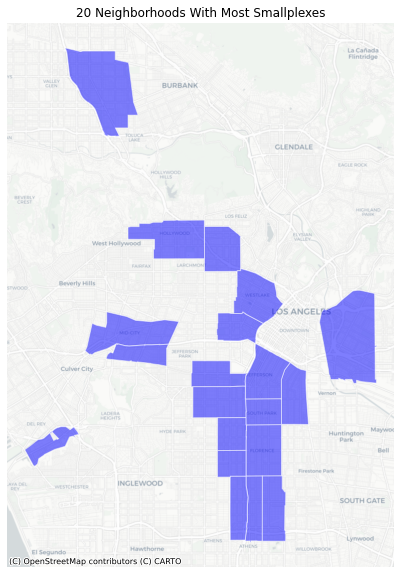

In [31]:
fig,ax = plt.subplots(figsize=(12,10))
Neighborhood_Boundaries.sort_values(by='smallplexes',ascending=False)[:20].plot(ax=ax,
                                                                 color='blue',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('20 Neighborhoods With Most Smallplexes')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

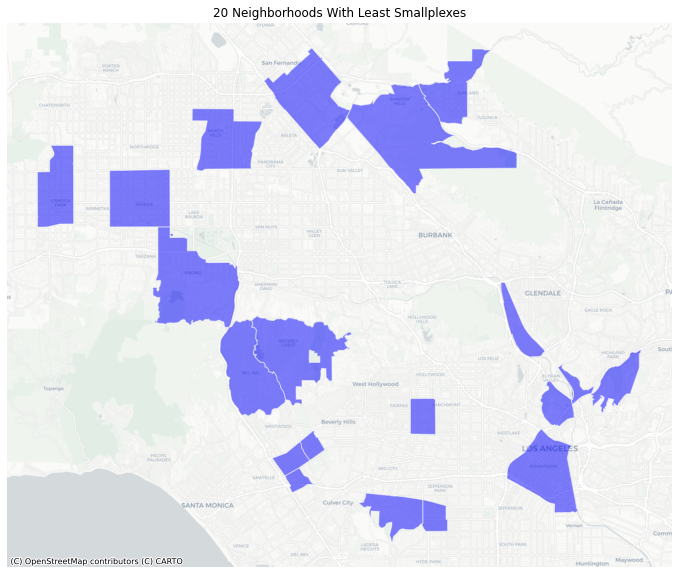

In [32]:
fig,ax = plt.subplots(figsize=(12,10))
Neighborhood_Boundaries.sort_values(by='smallplexes',ascending=True)[:20].plot(ax=ax,
                                                                 color='blue',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('20 Neighborhoods With Least Smallplexes')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Step 12

I then did a chloropleth map to show the relationship that neighborhoods with large numbers of smallplexes have with neighborhoods with small numbers of smallplexes.

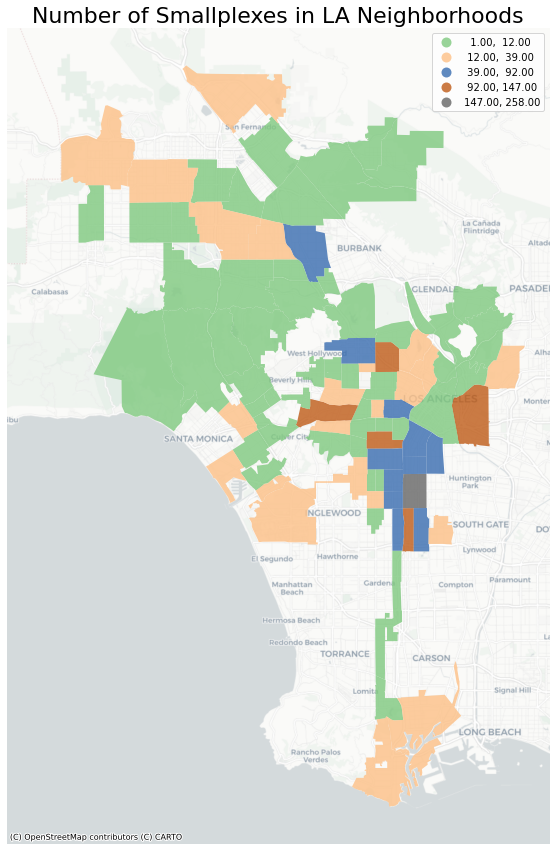

In [33]:
fig,ax = plt.subplots(figsize=(15,15))

Neighborhood_Boundaries.plot(ax=ax,
        column='smallplexes',
        legend=True,
        alpha=0.8,
        cmap='Accent',
        scheme='natural_breaks')

ax.axis('off')
ax.set_title('Number of Smallplexes in LA Neighborhoods',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Step 13

The following are just interactive maps that I created last time that include a loop function

In [34]:
def smallplex_map(Dwelling = '2'):
    
    Table = px.scatter_mapbox(Smallplex_Data_With_Geometry[Smallplex_Data_With_Geometry['# of Residential Dwelling Units'] == Dwelling],
                                                      lat='Latitude',
                        lon='Longitude',
                          color= '# of Residential Dwelling Units')
    Table.update_layout(mapbox_style="carto-darkmatter")

    Table.show()

In [35]:
smallplex_list = Smallplex_Data_With_Geometry['# of Residential Dwelling Units'].unique().tolist()
smallplex_list

['4', '3', '2']

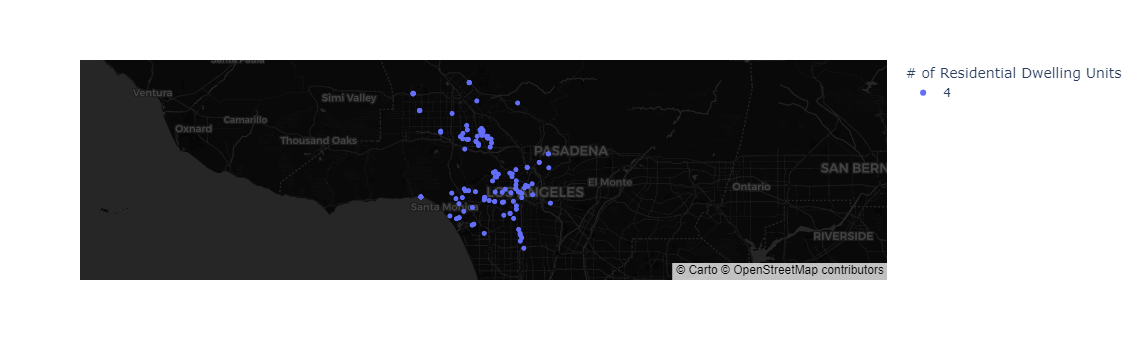

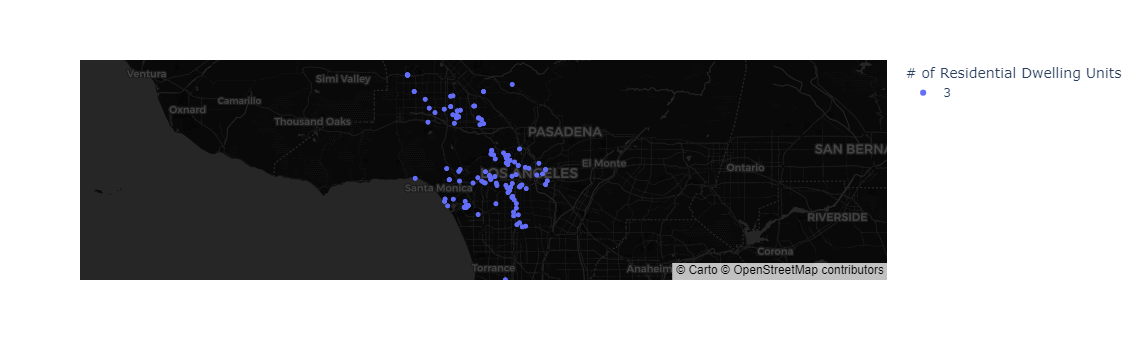

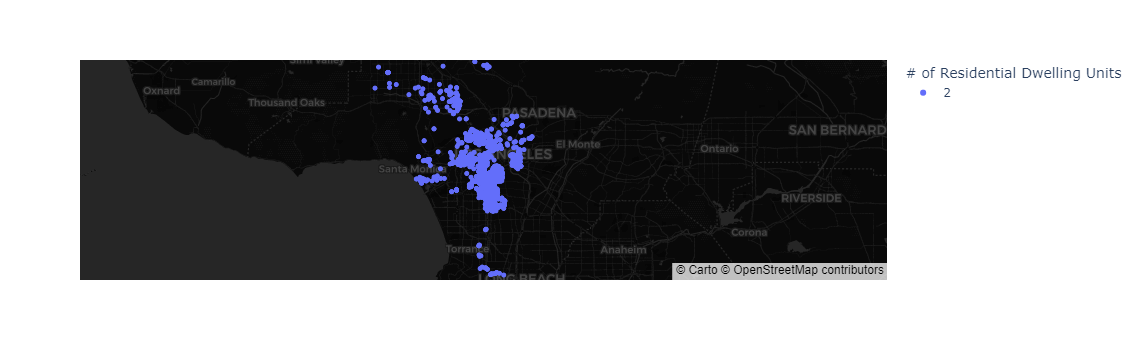

In [36]:
for Dwelling in smallplex_list:
    smallplex_map(Dwelling)